Dalam dunia analisis data, Apache Airflow telah menjadi salah satu alat yang sangat populer untuk mengelola alur kerja (workflow) secara otomatis. Dengan fitur-fitur yang kuat, Airflow memungkinkan pengguna untuk membuat dan menjadwalkan DAG (Directed Acyclic Graph) yang kompleks untuk berbagai kebutuhan. Dalam artikel ini, kami akan memandu Anda melalui langkah-langkah untuk mengimplementasikan DAG sederhana dan menjadwalkannya menggunakan Apache Airflow, serta memberikan informasi tentang sintaks cron untuk penjadwalan.

Kita akan membuat sebuah DAG sederhana yang memiliki tiga task dengan dependency seperti berikut:

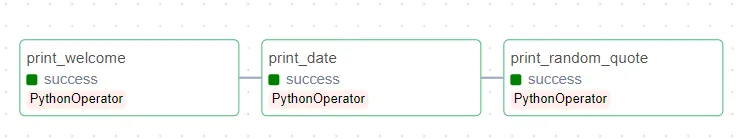

## Langkah 1: Instalasi Apache Airflow

Pertama-tama, pastikan Anda memiliki Apache Airflow terinstal di komputer Anda. Apabila Anda menggunakan OS Ubuntu, MAC, atau anaconda environment, Anda dapat menginstalnya menggunakan pip (Python Package Installer) dengan perintah:

```
pip install apache-airflow
```

Lalu lakukan inisialisasi airflow menggunakan perintah:

```
airflow initdb
```

Apabila Anda menggunakan Windows OS, Langkah-langkah instalasi Apache Airflow dapat Anda ikuti pada artikel berikut.

## Langkah 2: Membuat Helper function

Ketika Anda melakukan instalasi Airflow, Anda akan memiliki struktur proyek seperti berikut:

```
- airflow-directory
  - config
  - dags
  - logs
  - plugins
  - .env
  - docker-compose.yaml
```

Anda dapat membuat sebuah folder yang berisi function untuk menjalankan sebuah task. Cara ini memungkinkan Anda untuk meningkatkan modularity dan reusability dari setiap python script yang Anda buat.

Hal pertama yang Anda lakukan adalah membuat file `__init__.py` dan biarkan kosong. File tersebut akan secara default membuat python mengenali setiap file berekstensi py sebagai python module.

Selanjutnya pada folder dag, buat folder baru yang nantinya akan diletakkan helper function untuk menjalankan task. Folder ini bernama function. Pada folder tersebut buat sebuah file `welcome_func.py` yang berisi code berikut:

```python
from datetime import datetime
import requests

def print_welcome():
    print('Welcome to Airflow!')

def print_date():
    print('Today is {}'.format(datetime.today().date()))

def print_random_quote():
    response = requests.get('https://api.quotable.io/random')
    quote = response.json()['content']
    print('Quote of the day: "{}"'.format(quote))
```

Secara sederhana function yang berada pada file welcome_func.py akan mencetak kalimat sesuai hal yang diinginkan. Function ini yang kemudian akan kita gunakan untuk mendefinisikan tiap task yang ada pada DAG kita.

## Langkah 3: Membuat DAG (DAG Instance)

Ketika Anda ingin membuat sebuah DAG, Anda harus meletakkan file tersebut di dalam folder dags agar dapat terbaca pada Airflow Web Server. Apabila Anda ingin merubah default folder penyimpanan DAGs, Anda dapat merubahnya pada file docker-compose.yaml.

Saat ini struktur project Anda akan sebagai berikut:

```
— airflow-directory
 — config
 — dags
  — function
   — welcome_func.py
 — logs
 — plugins
 — .env
 — docker-compose.yaml
```

Selanjutnya Anda buat sebuah file `welcome_dag.py` pada folder dags. Pada file tersebut Anda akan membuat sebuah DAG baru, mendefinisikan task dan dependency antar task. Tambahkan kode berikut pada file `welcome_dag.py` Anda.

```python
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.utils.dates import days_ago
from function.welcome_func import *
from datetime import timedelta

default_args = {
    'owner': 'Ichaa',
    'depends_on_past': False,
    'start_date': days_ago(1),
    'retries': 1,
    'retry_delay': timedelta(seconds=10),
    'catchup': False
}

dag = DAG(
    'welcome_dag',
    default_args= default_args,
    schedule_interval='0 23 * * *',
    catchup=False
)
```

Pada kode diatas, Anda akan membuat sebuah DAG baru yang bernama welcome_dag. Pada DAG tersebut Anda dapat melakukan konfigurasi dan menambahkan informasi tentang DAG tersebut pada parameter default_args.

Salah satu konfigurasi yang penting ketika menginstansiasi sebuah DAG adalah penjadwalan. Penjadwalan pada Airflow dituliskan menggunakan sintaks cron. Berikut beberapa sintaks cron yang paling umum digunakan untuk penjadwalan.

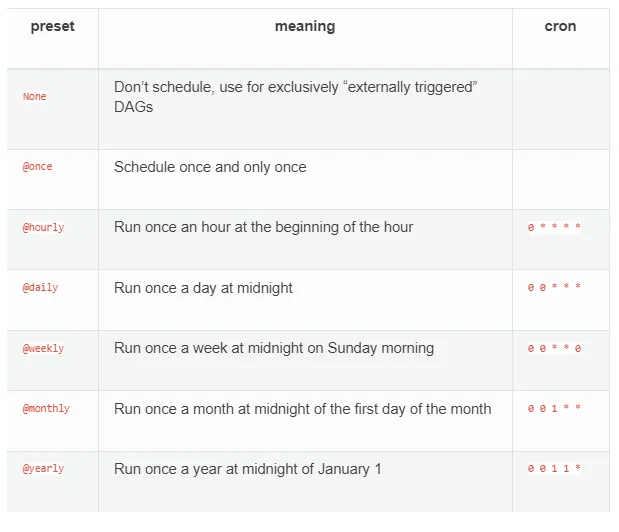

Apabila Anda ingin mengkustomisasi penjadwalan pada airflow, Anda dapat merubah sintaks cron tersebut. Berikut contoh kustomisasi sintaks cron.

- 0 2 * * *: Menjalankan tugas setiap hari pukul 2 pagi.
- 30 8 * * 1–5: Menjalankan tugas setiap hari Senin hingga Jumat pukul 8:30 pagi.
- 0 0 1 * *: Menjalankan tugas setiap awal bulan pukul 12 tengah malam.
- 0 0 * * 6: Menjalankan tugas setiap Sabtu pukul 12 tengah malam.

Untuk informasi lebih lengkap mengenai sintaks cron Anda dapat membaca pada [link](https://en.wikipedia.org/wiki/Cron) berikut.

## Langkah 4: Mendefinisikan Task

Setelah menginstansiasi DAG, Hal yang selanjutnya dilakukan adalah mendefinisikan setiap task dan dependency antar task. Ketika Anda mendefinisikan sebuah task, terdapat beberapa operator yang dapat Anda gunakan seperti BashOperator untuk mengeksekusi bash commands, PythonOperator untuk memanggil Python function, EmailOperator untuk mengirim email dan lain sebagainya.

Pada implementasi kali ini kita hanya akan menggunakan PythonOperator untuk memanggil fungsi yang sudah kita buat sebelumnya pada file welcome_func.py

Pada file `welcome_dag.py` tambahkan kode berikut.

```python
print_welcome_task = PythonOperator(
    task_id='print_welcome',
    python_callable=print_welcome,
    dag=dag
)

print_date_task = PythonOperator(
    task_id='print_date',
    python_callable=print_date,
    dag=dag
)

print_random_quote = PythonOperator(
    task_id='print_random_quote',
    python_callable=print_random_quote,
    dag=dag
)

# Set the dependencies between the tasks
print_welcome_task >> print_date_task >> print_random_quote
```

Kode di atas mendefinisikan tiga task PythonOperator dalam sebuah DAG. Setiap task memiliki identifikasi (task_id) yang unik dan fungsi Python yang akan dijalankan (python_callable). Setiap task tersebut akan menjalankan fungsi python yang sudah kita buat sebelumnya pada file welcome_func.py.

Pada kode tersebut, kita juga mendefinisikan dependency antar task dengan menggunakan operator “>>”. Ini menunjukkan bahwa print_date_task akan dijalankan setelah print_welcome_task, dan print_random_quote akan dijalankan setelah print_date_task.

## Langkah 5: Jalankan Airflow

Kita telah membuat DAG dan mendefinisikan task-task didalamnya. Saat ini struktur project Anda akan terlihat seperti berikut.

```
— airflow-directory
 — config
 — dags
  — function
   — welcome_func.py
  — welcome_dag.py
 — logs
 — plugins
 — .env
 — docker-compose.yaml
```

Hal yang selanjutnya dilakukan adalah menjalankan Apache Airflow. Apabila Anda melakukan instalasi Apache Airflow melalui docker, hal pertama yang Anda l

akukan adalah membuka docker desktop terlebih dahulu.

Berikut adalah tampilan docker desktop Anda.

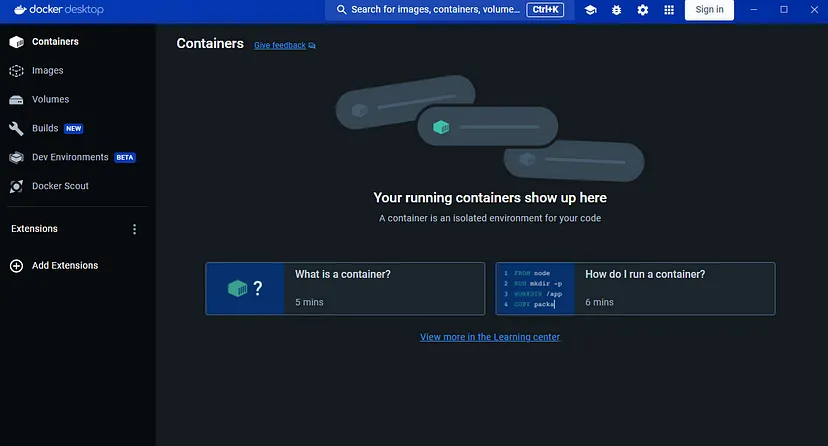

Selanjutnya buka terminal Anda dan arahkan pada direktori(folder) tempat anda bekerja. Jalankan command berikut pada terminal.

```
docker compose up -d
```

Saat Anda menjalankan Airflow menggunakan docker compose, Anda menggunakan perintah docker compose up -d untuk memulai layanan Airflow dalam proses background. Ini akan menyebabkan docker compose membaca file konfigurasi docker-compose.yml di direktori kerja Anda dan menjalankan semua layanan yang didefinisikan di dalamnya.

Opsi -d digunakan agar layanan berjalan dalam mode background, memungkinkan Anda untuk melanjutkan penggunaan terminal Anda tanpa harus menunggu proses selesai. Setelah perintah dieksekusi, Docker akan mulai mengunduh dan menginstal semua kontainer yang diperlukan, termasuk Airflow dan dependency-nya. Dengan ini, Airflow akan siap digunakan dalam waktu singkat.

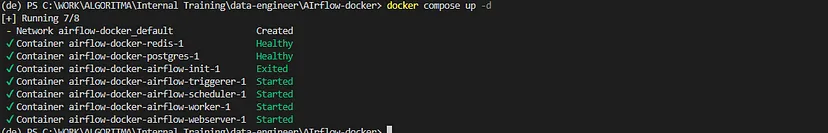

Setelah perintah tersebut dieksekusi, Anda akan melihat informasi container apa saja yang dijalankan pada terminal. Anda juga dapat melihatnya melalui docker desktop.

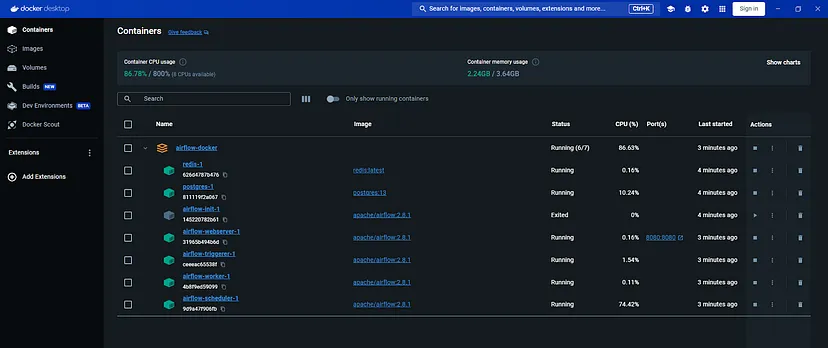

Untuk mengakses Airflow Web Server, Anda bisa masuk ke localhost:8080 atau klik pada port berwarna biru pada docker desktop Anda.

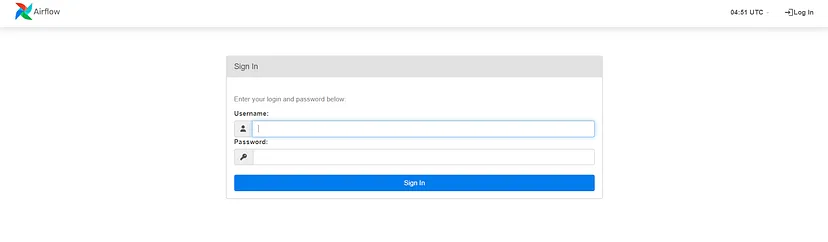

Anda akan diarahkan pada halaman sign in di Airflow Web Server. Pada tutorial instalasi sebelumnya, Apache Airflow akan secara default membuat satu user baru dengan username airflow dan password airflow. Pada Airflow, Anda dapat menambahkan user baru. Namun untuk saat ini kita akan menggunakan default user dari Airflow saja.

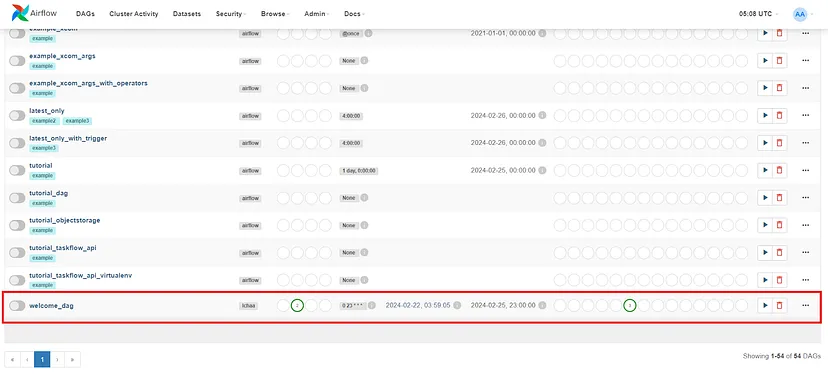

Anda akan menemukan DAG yang sudah dibuat sebelumnya pada halaman DAG list. Terdapat toggle button yang menunjukkan apakah DAG tersebut aktif atau tidak. Kita akan coba menjalankan DAG tersebut.

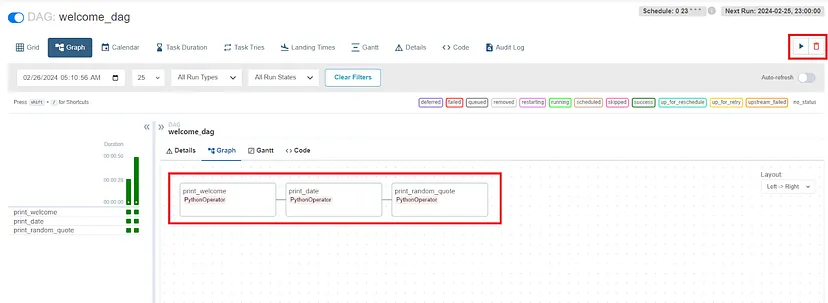

Ketika Anda mengklik sebuah DAG, Anda akan masuk ke halaman yang berisi detail DAG tersebut. Anda dapat melihat informasi task pada DAG, schedule, dan mengatur beberapa konfigurasi untuk DAG Anda.

Selanjutnya kita akan coba jalankan welcome_dag. Untuk mentrigger DAG agar berjalan, Anda dapat klik pada bagian kanan atas tombol play. Tombol tersebut akan mentrigger task dijalankan.

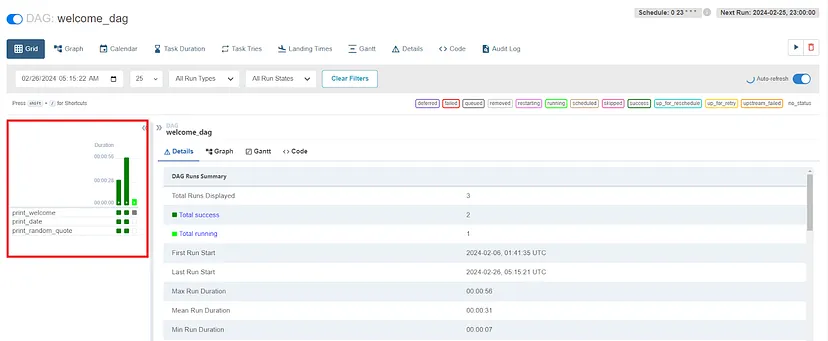

Anda dapat melihat apakah seluruh task dijalankan dengan baik pada bagian berkotak merah. Apabila seluruh task berwarna hijau, maka task berjalan dengan baik tanpa error.

Apabila Anda ingin melihat detail dari setiap task, Anda dapat mengklik salah satu task. Kemudian akan ditampilkan informasi mengenai task tersebut seperti code dan log proses. Kita akan contohkan pada salah satu task yaitu print_welcome. Task print_welcome bertugas menampilkan kalimat “welcome to Airflow!” pada console. Anda dapat melihatnya pada bagian task log dan menemukan kalimat tersebut.

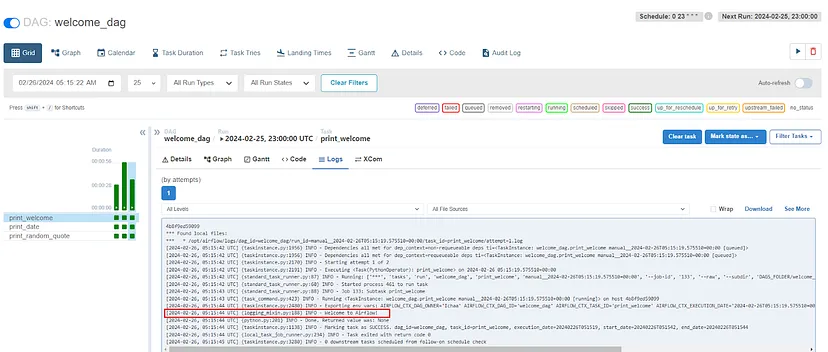

Dengan demikian, Anda telah berhasil mempelajari cara sederhana dalam mengimplementasikan Apache Airflow. Apache Airflow menawarkan kemudahan dalam pengaturan workflow yang kompleks dalam optimasi pengolahan data. Sehingga workflow data Anda menjadi lebih efisien dan efektif.